<a href="https://colab.research.google.com/github/OmerCahana/C-Lab/blob/master/Unsupervised_learning_for_facial_reenactment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Name**: Omer cahana

## **ID** : 203166764

## **Title** :Unsupervised learning for facial reenactment

## **Aims**
Build an approach that enables photo-realistic re-animation of portrait videos using only an input video

## **Reasnable **
Synthesizing and editing video portraits, i.e., videos framed to show
a person’s head and upper body, is an important problem in computer graphics, with applications in video editing and movie postproduction, visual efects, visual dubbing, virtual reality, and telepresence, among others.

## **Dataset**

FaceWarehouse dataset

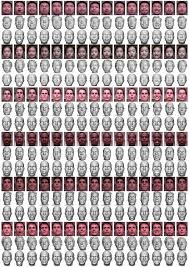

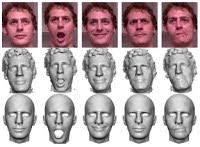

## **approach**

There is a big buzz on vid2vid GAN model and i'll like to explore this model. 
The paper that i based on (that you will see in the next cell), is use VAE.





## **preliminary results**

The core of the approach is a generative neural network with a novel space-time architecture. The network takes as input synthetic renderings of a parametric face model, based on which it predicts photo-realistic video frames for a given target actor

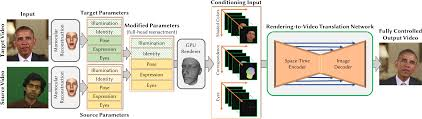

Deep video portraits enable a source actor to fully control a target video portrait. First, a low-dimensional parametric representation (let) of both
videos is obtained using monocular face reconstruction. The head pose, expression and eye gaze can now be transferred in parameter space (middle). We do not
focus on the modification of the identity and scene illumination (hatched background), since we are interested in reenactment. Finally, we render conditioning
input images that are converted to a photo-realistic video portrait of the target actor (right). Obama video courtesy of the White House (public domain)

[Deep Video Portraits](https://www.youtube.com/watch?v=qc5P2bvfl44)



## **You must to try it! its take 10 hours of training to create the video.**

**upload two videos: source video and target video. The model will tranform source face to target face** 


In [0]:
!git clone https://github.com/shaoanlu/faceswap-GAN.git
  
%cd "faceswap-GAN"  

**Upload training videos**

In [0]:
from google.colab import files

# Upload source video
source_video = files.upload()

for fn_source_video, _ in source_video.items():
    print(fn_source_video)

In [0]:
# Upload target video
target_video = files.upload()

for fn_target_video, _ in target_video.items():
    print(fn_target_video)

In [0]:
global TOTAL_ITERS
TOTAL_ITERS = 34000

## **FROM HERE JUST PRESS CTRL+F10**

 The result video can be downloaded by running the last cell:

  files.download("OUTPUT_VIDEO.mp4")
  Some browsers do not support this line (e.g., Opera does not pop up a save dialog). Please use Firefox or Chrome.
Notice that this page should not be closed or refreshed while running.

In [0]:
%%capture
!pip install moviepy
!pip install keras_vggface
import imageio
imageio.plugins.ffmpeg.download()

import keras.backend as K
from detector.face_detector import MTCNNFaceDetector
import glob

from preprocess import preprocess_video

fd = MTCNNFaceDetector(sess=K.get_session(), model_path="./mtcnn_weights/")

!mkdir -p faceA/rgb
!mkdir -p faceA/binary_mask
!mkdir -p faceB/rgb
!mkdir -p faceB/binary_mask

In [0]:
save_interval = 5 # perform face detection every {save_interval} frames
save_path = "./faceA/"
preprocess_video(fn_source_video, fd, save_interval, save_path)
save_path = "./faceB/"
preprocess_video(fn_target_video, fd, save_interval, save_path)

print(str(len(glob.glob("faceA/rgb/*.*"))) + " face(s) extracted from source video: " + fn_source_video + ".")
print(str(len(glob.glob("faceB/rgb/*.*"))) + " face(s) extracted from target video: " + fn_target_video + ".")

In [0]:
from keras.layers import *
import keras.backend as K
import tensorflow as tf

import os
import cv2
import glob
import time
import numpy as np
from pathlib import PurePath, Path
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
K.set_learning_phase(1)
# Number of CPU cores
num_cpus = os.cpu_count()

# Input/Output resolution
RESOLUTION = 64 # 64x64, 128x128, 256x256
assert (RESOLUTION % 64) == 0, "RESOLUTION should be 64, 128, or 256."

# Batch size
batchSize = 4

# Use motion blurs (data augmentation)
# set True if training data contains images extracted from videos
use_da_motion_blur = False 

# Use eye-aware training
# require images generated from prep_binary_masks.ipynb
use_bm_eyes = True

# Probability of random color matching (data augmentation)
prob_random_color_match = 0.5

da_config = {
    "prob_random_color_match": prob_random_color_match,
    "use_da_motion_blur": use_da_motion_blur,
    "use_bm_eyes": use_bm_eyes
}

# Path to training images
img_dirA = './faceA/rgb'
img_dirB = './faceB/rgb'
img_dirA_bm_eyes = "./faceA/binary_mask"
img_dirB_bm_eyes = "./faceB/binary_mask"

# Path to saved model weights
models_dir = "./models"

# Architecture configuration
arch_config = {}
arch_config['IMAGE_SHAPE'] = (RESOLUTION, RESOLUTION, 3)
arch_config['use_self_attn'] = True
arch_config['norm'] = "hybrid" # instancenorm, batchnorm, layernorm, groupnorm, none
arch_config['model_capacity'] = "lite" # standard, lite

# Loss function weights configuration
loss_weights = {}
loss_weights['w_D'] = 0.1 # Discriminator
loss_weights['w_recon'] = 1. # L1 reconstruction loss
loss_weights['w_edge'] = 0.1 # edge loss
loss_weights['w_eyes'] = 30. # reconstruction and edge loss on eyes area
loss_weights['w_pl'] = (0.01, 0.1, 0.3, 0.1) # perceptual loss (0.003, 0.03, 0.3, 0.3)

# Init. loss config.
loss_config = {}
loss_config["gan_training"] = "mixup_LSGAN"
loss_config['use_PL'] = False
loss_config["PL_before_activ"] = True
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 1.
loss_config['use_cyclic_loss'] = False

In [0]:
from networks.faceswap_gan_model import FaceswapGANModel
from data_loader.data_loader import DataLoader
from utils import showG, showG_mask, showG_eyes

In [0]:
model = FaceswapGANModel(**arch_config)
%%capture
!wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_resnet50.h5

In [0]:
#from keras_vggface.vggface import VGGFace

# VGGFace ResNet50
#vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))'

from colab_demo.vggface_models import RESNET50
vggface = RESNET50(include_top=False, weights=None, input_shape=(224, 224, 3))
vggface.load_weights("rcmalli_vggface_tf_notop_resnet50.h5")

#from keras.applications.resnet50 import ResNet50
#vggface = ResNet50(include_top=False, input_shape=(224, 224, 3))

#vggface.summary()

model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])
model.build_train_functions(loss_weights=loss_weights, **loss_config)

# Create ./models directory
Path(f"models").mkdir(parents=True, exist_ok=True)

# Get filenames
train_A = glob.glob(img_dirA+"/*.*")
train_B = glob.glob(img_dirB+"/*.*")

train_AnB = train_A + train_B

assert len(train_A), "No image found in " + str(img_dirA)
assert len(train_B), "No image found in " + str(img_dirB)
print ("Number of images in folder A: " + str(len(train_A)))
print ("Number of images in folder B: " + str(len(train_B)))

In [0]:
def show_loss_config(loss_config):
    for config, value in loss_config.items():
        print(f"{config} = {value}")

In [0]:
def reset_session(save_path):
    global model, vggface
    global train_batchA, train_batchB
    model.save_weights(path=save_path)
    del model
    del vggface
    del train_batchA
    del train_batchB
    K.clear_session()
    model = FaceswapGANModel(**arch_config)
    model.load_weights(path=save_path)
    #vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))
    vggface = RESNET50(include_top=False, weights=None, input_shape=(224, 224, 3))
    vggface.load_weights("rcmalli_vggface_tf_notop_resnet50.h5")
    model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])
    train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes,
                              RESOLUTION, num_cpus, K.get_session(), **da_config)
    train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                              RESOLUTION, num_cpus, K.get_session(), **da_config)

In [0]:
# Start training
t0 = time.time()

# This try/except is meant to resume training if we disconnected from Colab
try:
    gen_iterations
    print(f"Resume training from iter {gen_iterations}.")
except:
    gen_iterations = 0

errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
errGAs = {}
errGBs = {}
# Dictionaries are ordered in Python 3.6
for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
    errGAs[k] = 0
    errGBs[k] = 0

display_iters = 300
global TOTAL_ITERS

global train_batchA, train_batchB
train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)

while gen_iterations <= TOTAL_ITERS: 
    
    # Loss function automation
    if gen_iterations == (TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//5 + TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.5
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Complete.")
    elif gen_iterations == (2*TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.2
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//2 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.4
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (2*TOTAL_ITERS//3 - display_iters//2):
        clear_output()
        model.decoder_A.load_weights("models/decoder_B.h5") # swap decoders
        model.decoder_B.load_weights("models/decoder_A.h5") # swap decoders
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.5
        loss_config['lr_factor'] = 1
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (8*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.1
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (9*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        loss_config['lr_factor'] = 0.1
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    
    if gen_iterations == 5:
        print ("working.")
    
    # Train dicriminators for one batch
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
    errDA_sum +=errDA[0]
    errDB_sum +=errDB[0]

    # Train generators for one batch
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)
    errGA_sum += errGA[0]
    errGB_sum += errGB[0]
    for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
        errGAs[k] += errGA[i]
        errGBs[k] += errGB[i]
    gen_iterations+=1
    
    # Visualization
    if gen_iterations % display_iters == 0:
        clear_output()
            
        # Display loss information
        show_loss_config(loss_config)
        print("----------") 
        print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
        % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
        print("----------") 
        print("Generator loss details:")
        print(f'[Adversarial loss]')  
        print(f'GA: {errGAs["adv"]/display_iters:.4f} GB: {errGBs["adv"]/display_iters:.4f}')
        print(f'[Reconstruction loss]')
        print(f'GA: {errGAs["recon"]/display_iters:.4f} GB: {errGBs["recon"]/display_iters:.4f}')
        print(f'[Edge loss]')
        print(f'GA: {errGAs["edge"]/display_iters:.4f} GB: {errGBs["edge"]/display_iters:.4f}')
        if loss_config['use_PL'] == True:
            print(f'[Perceptual loss]')
            try:
                print(f'GA: {errGAs["pl"][0]/display_iters:.4f} GB: {errGBs["pl"][0]/display_iters:.4f}')
            except:
                print(f'GA: {errGAs["pl"]/display_iters:.4f} GB: {errGBs["pl"]/display_iters:.4f}')
        
        # Display images
        print("----------") 
        wA, tA, _ = train_batchA.get_next_batch()
        wB, tB, _ = train_batchB.get_next_batch()
        print("Transformed (masked) results:")
        showG(tA, tB, model.path_A, model.path_B, batchSize)   
        print("Masks:")
        showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize)  
        print("Reconstruction results:")
        showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize)           
        errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
        for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
            errGAs[k] = 0
            errGBs[k] = 0
        
        # Save models
        model.save_weights(path=models_dir)

In [0]:
from converter.video_converter import VideoConverter

global model, vggface
global train_batchA, train_batchB
del model
del vggface
del train_batchA
del train_batchB
tf.reset_default_graph()
K.clear_session()
model = FaceswapGANModel(**arch_config)
model.load_weights(path=models_dir)

fd = MTCNNFaceDetector(sess=K.get_session(), model_path="./mtcnn_weights/")
vc = VideoConverter()
vc.set_face_detector(fd)
vc.set_gan_model(model)

In [0]:
options = {
    # ===== Fixed =====
    "use_smoothed_bbox": True,
    "use_kalman_filter": True,
    "use_auto_downscaling": False,
    "bbox_moving_avg_coef": 0.65,
    "min_face_area": 35 * 35,
    "IMAGE_SHAPE": model.IMAGE_SHAPE,
    # ===== Tunable =====
    "kf_noise_coef": 1e-3,
    "use_color_correction": "hist_match",
    "detec_threshold": 0.8,
    "roi_coverage": 0.9,
    "enhance": 0.,
    "output_type": 3,
    "direction": "AtoB", # ==================== This line determines the transform direction ====================
}

In [0]:
if options["direction"] == "AtoB":
    input_fn = fn_source_video
    output_fn = "OUTPUT_VIDEO_AtoB.mp4"
elif options["direction"] == "BtoA":
    input_fn = fn_target_video
    output_fn = "OUTPUT_VIDEO_BtoA.mp4"

duration = None # None or a non-negative float tuple: (start_sec, end_sec). Duration of input video to be converted

vc.convert(input_fn=input_fn, output_fn=output_fn, options=options, duration=duration)

In [0]:
from google.colab import files

if options["direction"] == "AtoB":
    files.download("OUTPUT_VIDEO_AtoB.mp4")
elif options["direction"] == "BtoA":
    files.download("OUTPUT_VIDEO_BtoA.mp4")